In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 750078851711888019
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5584846848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8313746798149497132
physical_device_desc: "device: 0, name: Tesla K20Xm, pci bus id: 0000:20:00.0, compute capability: 3.5"
]


In [10]:
import random
import pylab as pl
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [9]:
import pickle

with open('standarized_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_sn = pickle.load(filehandle)

with open('flux_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    flux_sn = pickle.load(filehandle)

with open('flux_host.data', 'rb') as filehandle:
    # read the data as binary data stream
    flux_host = pickle.load(filehandle)

with open('standarized_hosts.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_host = pickle.load(filehandle)

with open('wave_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    wave_em_sn = pickle.load(filehandle)

with open('wave_host.data', 'rb') as filehandle:
    # read the data as binary data stream
    wave_em_host = pickle.load(filehandle)

with open('wave_obs.data', 'rb') as filehandle:
    # read the data as binary data stream
    wave_obs = pickle.load(filehandle)

In [3]:
with open('standarized_em_host.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_em_host = pickle.load(filehandle)
with open('standarized_em_sn.data', 'rb') as filehandle:
    # read the data as binary data stream
    standarized_em_sn = pickle.load(filehandle)

In [5]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.layers import (Input, Dense, Activation, ZeroPadding1D, 
BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout,Add, LSTM,Embedding)
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

from tensorflow.keras import utils


#from desispec.interpolation import resample_flux

from tensorflow.keras import backend as K

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
#plt.rcParamsDefault['axes.prop_cycle']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rc('grid',alpha=0.3,linestyle='--')


from keras import backend as K
def network(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """ 
    Args:
    input_shape -- shape of the input spectra
    regularization_strength -- regularization factor
    dropout -- dropout rate
    seed -- seed of initializer
    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='Input_Spec')

    with K.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    with K.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
    with K.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    with K.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

        
    # FLATTEN -> FULLYCONNECTED
    with K.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    with K.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [21]:
def roc_pr_cm_hist(X,y):
    # Splitting the data 
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25)
    """Trying from the blog"""
    from keras.models import Sequential
    from keras.layers import Dense
    # Classifier
    from keras.wrappers.scikit_learn import KerasClassifier
    keras_model = network((400,1))

    keras_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

    from sklearn.metrics import roc_curve
    y_pred_keras = keras_model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

    # Area under the curve
    from sklearn.metrics import auc
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    ############
    import random
    import pylab as pl
    import numpy as np
    from sklearn import svm, datasets
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc

    """# The source code uses decision_function
    but that is only applicable to sequential class and not the model class that our classifer uses.
    Check here for more reference: https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun"""
    y_score = keras_model.predict(X_test).ravel() 


    # Average precision score
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    #https://scikit-plot.readthedocs.io/en/stable/Quickstart.html
    #Used Professor's Benzvi's code for PR curve

    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_keras)
    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve with average precision of {0:0.2f}'.format(average_precision))
    
    ########
    
    from sklearn.metrics import confusion_matrix

    y_pred = y_pred_keras

    def plotConfusionMatrix(y_true, y_pred, classes=["Hosts", "Type IAs", "Type IIPs"], cmap=plt.cm.gray, title="Normalized Confusion Matrix"):
        from sklearn.metrics import accuracy_score
        from sklearn.metrics import confusion_matrix
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        #print(cm)
        print("Accuracy: ", accuracy_score(y_true, y_pred))
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        # create text annotations
        fmt = '.3f'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] < thresh else "black")
        fig.tight_layout()
        plt.ylim([1.5, -.5])

        plt.show()
        return ax

    for i in range(len(y_pred)):
        y_pred[i]=round(y_pred[i])

    plotConfusionMatrix(y_true=y_test, y_pred=y_pred, title="Normalized Conf. Matrix")
    
    ###################
    history = keras_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), shuffle=True)
    plt.plot(history.history['acc']) 
    plt.plot(history.history['val_acc']) 
    plt.ylabel('accuracy') 
    a = np.mean(hist.history['acc'])
    v = np.mean(hist.history['val_acc'])
    plt.title('mean_acc = {0:0.3f}, mean_val_acc = {1:0.3f}'.format(a,v))
    plt.ylim([0.5, 1.0])
    plt.xlabel('epoch') 
    plt.legend(['acc', 'val_acc'], loc='best') 
    plt.show()

In [24]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
X = np.concatenate([standarized_sn,standarized_host]).reshape(-1,400,1)
y = np.concatenate([np.zeros(standarized_sn.shape[0]),np.ones(standarized_host.shape[0])])

In [25]:
model2 = network((400,1))

In [26]:
permute = np.random.permutation(y.shape[0])
l = len(X)
hist = model2.fit(X[permute][:l],y[permute][:l],batch_size=64,epochs=50,validation_split=0.25,shuffle=True)

Train on 11184 samples, validate on 3729 samples
Epoch 1/50
11184/11184 [==============================] - 4s 318us/sample - loss: 1.7230 - acc: 0.6681 - val_loss: 1.4087 - val_acc: 0.6527
Epoch 2/50
11184/11184 [==============================] - 2s 218us/sample - loss: 1.1534 - acc: 0.7142 - val_loss: 1.1170 - val_acc: 0.7468
Epoch 3/50
11184/11184 [==============================] - 2s 219us/sample - loss: 0.9227 - acc: 0.7480 - val_loss: 0.9009 - val_acc: 0.7731
Epoch 4/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.8005 - acc: 0.7704 - val_loss: 0.8061 - val_acc: 0.7691
Epoch 5/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.7039 - acc: 0.7953 - val_loss: 1.5151 - val_acc: 0.6669
Epoch 6/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.6219 - acc: 0.8269 - val_loss: 1.1504 - val_acc: 0.6895
Epoch 7/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.5539 - acc: 0.8530 - val_lo

In [2]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
a = np.mean(hist.history['acc'])
v = np.mean(hist.history['val_acc'])
plt.title('mean_acc = {0:0.3f}, mean_val_acc = {1:0.3f}'.format(a,v))
plt.ylabel('accuracy')
plt.ylim([.5,1])
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()
plt.tight_layout()

NameError: name 'plt' is not defined

Epoch 1/30
11184/11184 [==============================] - 3s 267us/sample - loss: 1.6805 - acc: 0.6595
Epoch 2/30
11184/11184 [==============================] - 2s 197us/sample - loss: 1.1173 - acc: 0.6999
Epoch 3/30
11184/11184 [==============================] - 2s 197us/sample - loss: 0.9013 - acc: 0.7389
Epoch 4/30
11184/11184 [==============================] - 2s 198us/sample - loss: 0.7725 - acc: 0.7665
Epoch 5/30
11184/11184 [==============================] - 2s 199us/sample - loss: 0.6780 - acc: 0.7942
Epoch 6/30
11184/11184 [==============================] - 2s 199us/sample - loss: 0.6037 - acc: 0.8246
Epoch 7/30
11184/11184 [==============================] - 2s 198us/sample - loss: 0.5521 - acc: 0.8376
Epoch 8/30
11184/11184 [==============================] - 2s 199us/sample - loss: 0.5171 - acc: 0.8482
Epoch 9/30
11184/11184 [==============================] - 2s 199us/sample - loss: 0.4836 - acc: 0.8588
Epoch 10/30
11184/11184 [==============================] - 2s 199us/sampl

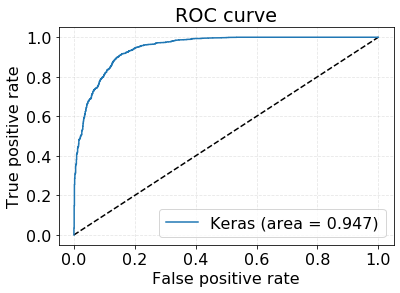

Average precision-recall score: 0.97
Normalized confusion matrix
Accuracy:  0.8836149101635827


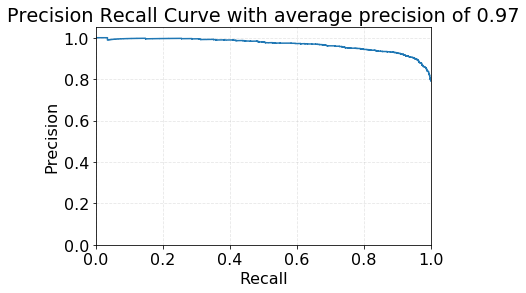

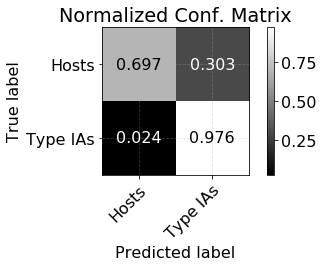

Train on 11184 samples, validate on 3729 samples
Epoch 1/50
11184/11184 [==============================] - 3s 258us/sample - loss: 0.2925 - acc: 0.9232 - val_loss: 0.8328 - val_acc: 0.8144
Epoch 2/50
11184/11184 [==============================] - 2s 219us/sample - loss: 0.2826 - acc: 0.9267 - val_loss: 0.5386 - val_acc: 0.8152
Epoch 3/50
11184/11184 [==============================] - 2s 219us/sample - loss: 0.2905 - acc: 0.9254 - val_loss: 0.3432 - val_acc: 0.8989
Epoch 4/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.2785 - acc: 0.9302 - val_loss: 1.5899 - val_acc: 0.7578
Epoch 5/50
11184/11184 [==============================] - 2s 219us/sample - loss: 0.2779 - acc: 0.9285 - val_loss: 0.5325 - val_acc: 0.8160
Epoch 6/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.2835 - acc: 0.9280 - val_loss: 0.5741 - val_acc: 0.8536
Epoch 7/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.2663 - acc: 0.9344 - val_lo

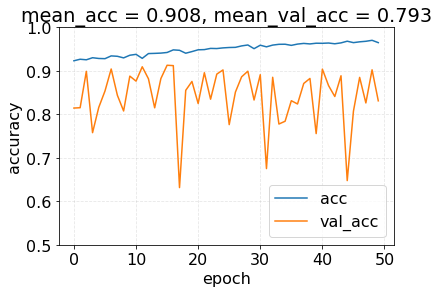

In [28]:
roc_pr_cm_hist(X=X,y=y)

In [33]:
X_em = np.concatenate([standarized_em_sn,standarized_em_host]).reshape(-1,400,1)
y_em = np.concatenate([np.zeros(standarized_em_sn.shape[0]),np.ones(standarized_em_host.shape[0])])

Epoch 1/30
11184/11184 [==============================] - 3s 263us/sample - loss: 1.8527 - acc: 0.6558
Epoch 2/30
11184/11184 [==============================] - 2s 194us/sample - loss: 1.2950 - acc: 0.6812
Epoch 3/30
11184/11184 [==============================] - 2s 194us/sample - loss: 1.0432 - acc: 0.6934
Epoch 4/30
11184/11184 [==============================] - 2s 194us/sample - loss: 0.8980 - acc: 0.7087
Epoch 5/30
11184/11184 [==============================] - 2s 194us/sample - loss: 0.8005 - acc: 0.7253
Epoch 6/30
11184/11184 [==============================] - 2s 194us/sample - loss: 0.7302 - acc: 0.7446
Epoch 7/30
11184/11184 [==============================] - 2s 194us/sample - loss: 0.6826 - acc: 0.7569
Epoch 8/30
11184/11184 [==============================] - 2s 198us/sample - loss: 0.6303 - acc: 0.7798
Epoch 9/30
11184/11184 [==============================] - 2s 194us/sample - loss: 0.5934 - acc: 0.7963
Epoch 10/30
11184/11184 [==============================] - 2s 193us/sampl

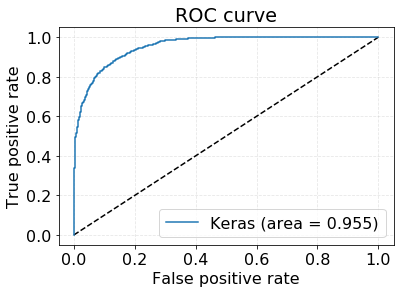

Average precision-recall score: 0.98
Normalized confusion matrix
Accuracy:  0.8809332260659695


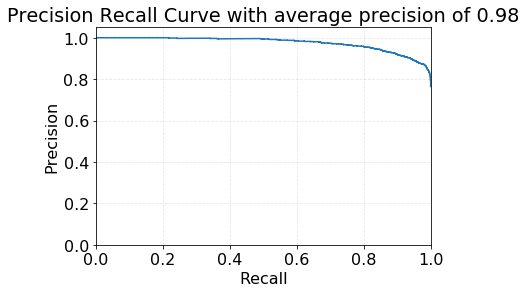

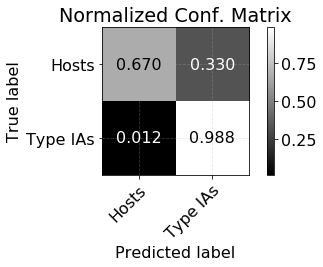

Train on 11184 samples, validate on 3729 samples
Epoch 1/50
11184/11184 [==============================] - 3s 265us/sample - loss: 0.3426 - acc: 0.9072 - val_loss: 0.5350 - val_acc: 0.8297
Epoch 2/50
11184/11184 [==============================] - 2s 214us/sample - loss: 0.3334 - acc: 0.9111 - val_loss: 1.5463 - val_acc: 0.4680
Epoch 3/50
11184/11184 [==============================] - 2s 214us/sample - loss: 0.3531 - acc: 0.8997 - val_loss: 0.8800 - val_acc: 0.6407
Epoch 4/50
11184/11184 [==============================] - 2s 214us/sample - loss: 0.3368 - acc: 0.9059 - val_loss: 0.9125 - val_acc: 0.6248
Epoch 5/50
11184/11184 [==============================] - 2s 215us/sample - loss: 0.3405 - acc: 0.9060 - val_loss: 2.0659 - val_acc: 0.5302
Epoch 6/50
11184/11184 [==============================] - 2s 214us/sample - loss: 0.3260 - acc: 0.9150 - val_loss: 1.0920 - val_acc: 0.6350
Epoch 7/50
11184/11184 [==============================] - 2s 214us/sample - loss: 0.3248 - acc: 0.9134 - val_lo

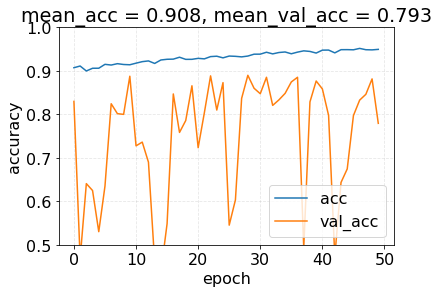

In [34]:
roc_pr_cm_hist(X=X_em,y=y_em)

In [31]:
permute = np.random.permutation(y_em.shape[0])
l = len(X_em)
hist1 = model2.fit(X_em[permute][:l],y_em[permute][:l],batch_size=64,epochs=50,
                  validation_split=0.25,shuffle=True)

Train on 11184 samples, validate on 3729 samples
Epoch 1/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.5768 - acc: 0.8058 - val_loss: 0.5615 - val_acc: 0.8123
Epoch 2/50
11184/11184 [==============================] - 3s 229us/sample - loss: 0.4834 - acc: 0.8457 - val_loss: 0.7066 - val_acc: 0.7144
Epoch 3/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.4324 - acc: 0.8682 - val_loss: 1.3215 - val_acc: 0.5154
Epoch 4/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.4094 - acc: 0.8771 - val_loss: 0.5820 - val_acc: 0.7989
Epoch 5/50
11184/11184 [==============================] - 2s 220us/sample - loss: 0.3929 - acc: 0.8821 - val_loss: 0.6726 - val_acc: 0.7801
Epoch 6/50
11184/11184 [==============================] - 2s 218us/sample - loss: 0.3699 - acc: 0.8940 - val_loss: 0.4046 - val_acc: 0.8788
Epoch 7/50
11184/11184 [==============================] - 2s 217us/sample - loss: 0.3658 - acc: 0.8958 - val_lo

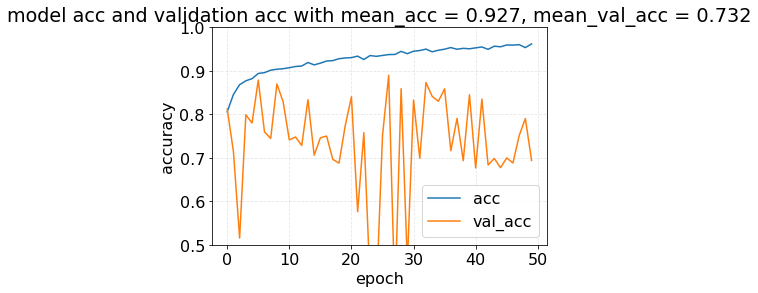

In [32]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
a = np.mean(hist1.history['acc'])
v = np.mean(hist1.history['val_acc'])
plt.title('model acc and validation acc with mean_acc = {0:0.3f}, mean_val_acc = {1:0.3f}'.format(a,v))
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()